In [91]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
import math
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic

%matplotlib inline 

завантаження даних

In [2]:
series = pd.read_excel('financial.xlsx')
series.head()

,quarter,GDP,Investment,Government Spending,M2,Key policy rate
0,1,20871,1744,6720,12835,35.0
1,2,23367,2675,7384,13257,41.0
2,3,28908,2877,8210,14142,51.0
3,4,29447,6662,8952,15432,82.0
4,5,24980,1861,6245,15631,60.0


In [3]:
series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   quarter              23 non-null     int64  
 1   GDP                  23 non-null     int64  
 2   Investment           23 non-null     int64  
 3   Government Spending  23 non-null     int64  
 4   M2                   23 non-null     int64  
 5   Key policy rate      23 non-null     float64
dtypes: float64(1), int64(5)
memory usage: 1.2 KB


зображуємо часовий ряд по змінній GDP

<Axes: >

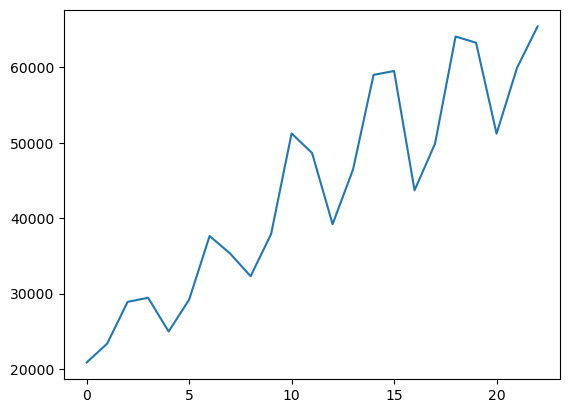

In [4]:
series['GDP'].plot()

є тренд ряд за графіком не є стаціонарним

зображуємо часовий ряд по змінній Investment

<Axes: >

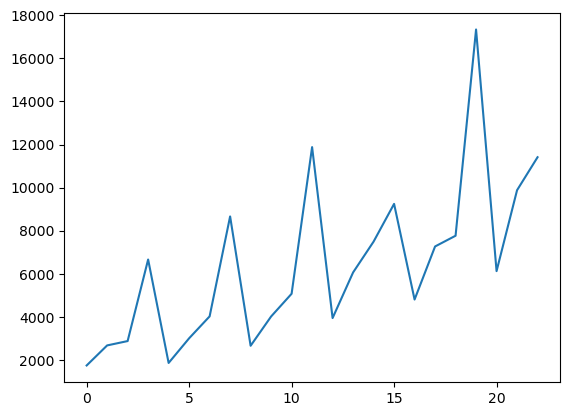

In [5]:
series['Investment'].plot()

на графіку видно, що є якась сезонність, ряд нестаціонарний 

зображуємо часовий ряд по змінній Key policy rate

<Axes: >

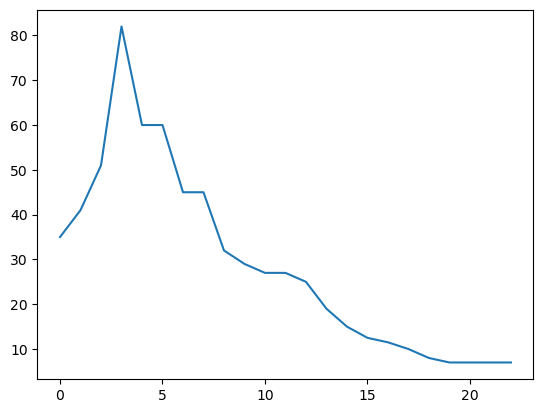

In [6]:
series['Key policy rate'].plot()

наявний тренд, ряд нестаціонарний

ВВП тест Діккі-Фулера 

In [7]:
test_stat, pvalue = adfuller(series['GDP'])[0:2]
pvalue

0.897969883183179

H0: The time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time.

HA: The time series is stationary.

висновок: Оскільки p-value не менше 0,05, ми не можемо відхилити нульову гіпотезу.

Це означає, що часовий ряд є нестаціонарним. Іншими словами, він має деяку залежну від часу структуру і не має постійної дисперсії в часі.

Інвестиції тест Діккі-Фулера

In [8]:
test_stat, pvalue = adfuller(series['Investment'])[0:2]
pvalue

0.9958016808571452

висновок: Оскільки p-value не є менше за 0,05, ми не можемо відхилити нульову гіпотезу. ряд нестаціонарний.

#### Облікова ставка тест Діккі-Фулера

In [9]:
test_stat, pvalue = adfuller(series['Key policy rate'])[0:2]
pvalue

0.6074875097438759

висновок: Оскільки p-value не є менше за 0,05, ми не можемо відхилити нульову гіпотезу. ряд нестаціонарний.

###### ряди мають бути стаціонарним аби побудувати модель, беремо ряди перших різниць для приведення до стаціонарності

In [10]:
series['Diff 1 GDP'] = series['GDP'].diff()
series['Diff 1 Investment'] = series['Investment'].diff()
series['Diff 1 Key policy rate'] = series['Key policy rate'].diff()

series.head()

,quarter,GDP,Investment,Government Spending,M2,Key policy rate,Diff 1 GDP,Diff 1 Investment,Diff 1 Key policy rate
0,1,20871,1744,6720,12835,35.0,NaN,NaN,NaN
1,2,23367,2675,7384,13257,41.0,2496.0,931.0,6.0
2,3,28908,2877,8210,14142,51.0,5541.0,202.0,10.0
3,4,29447,6662,8952,15432,82.0,539.0,3785.0,31.0
4,5,24980,1861,6245,15631,60.0,-4467.0,-4801.0,-22.0


*ВВП*

<Axes: >

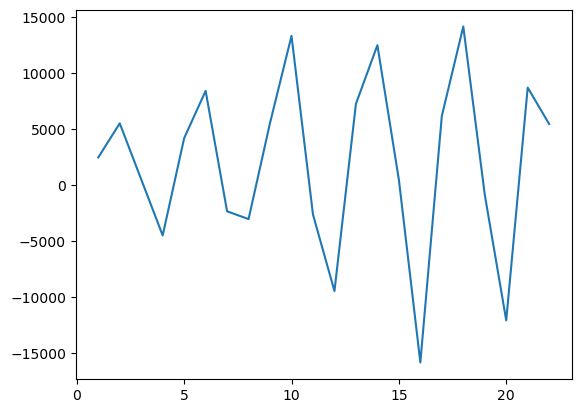

In [11]:
series['Diff 1 GDP'].plot()

Інвестиції

<Axes: >

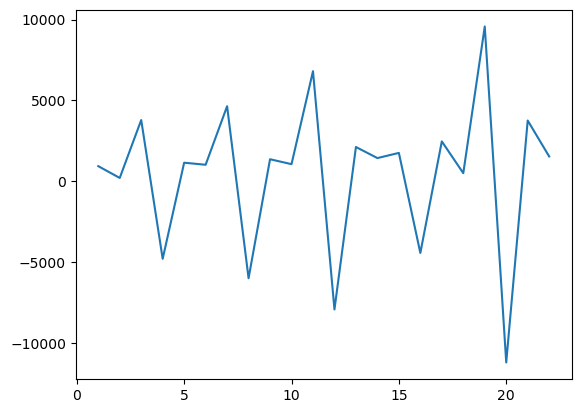

In [12]:
series['Diff 1 Investment'].plot()

*Облікова ставка*

<Axes: >

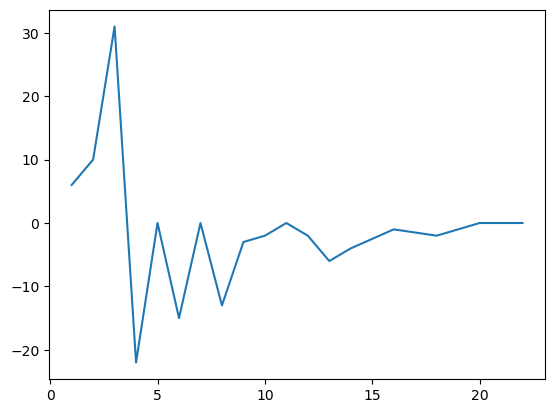

In [13]:
series['Diff 1 Key policy rate'].plot()

**Перевіримо на стаціонарність ряди перших різниць за тестом Діккі-Фулера:**

In [14]:
pvalue_GDP = adfuller(series['Diff 1 GDP'].dropna())[1]
pvalue_Investment = adfuller(series['Diff 1 Investment'].dropna())[1]
pvalue_KPR = adfuller(series['Diff 1 Key policy rate'].dropna())[1]

print(pvalue_GDP, pvalue_Investment, pvalue_KPR)

0.47013378146637336 1.5065836352424174e-11 1.0


Для показника інвестицій застосуємо ряд перших різниць для побудови моделі
Для інших двох показників будуємо ряд жругих різниць і перевіряємо на стаціонарність

In [15]:
series['Diff2 GDP'] = series['GDP'].diff(periods=2)
series['Diff2 Key policy rate'] = series['Key policy rate'].diff(periods=2)

series.head()

,quarter,GDP,Investment,Government Spending,M2,Key policy rate,Diff 1 GDP,Diff 1 Investment,Diff 1 Key policy rate,Diff2 GDP,Diff2 Key policy rate
0,1,20871,1744,6720,12835,35.0,NaN,NaN,NaN,NaN,NaN
1,2,23367,2675,7384,13257,41.0,2496.0,931.0,6.0,NaN,NaN
2,3,28908,2877,8210,14142,51.0,5541.0,202.0,10.0,8037.0,16.0
3,4,29447,6662,8952,15432,82.0,539.0,3785.0,31.0,6080.0,41.0
4,5,24980,1861,6245,15631,60.0,-4467.0,-4801.0,-22.0,-3928.0,9.0


In [16]:
pvalue_GDP = adfuller(series['Diff2 GDP'].dropna())[1]
pvalue_KPR = adfuller(series['Diff2 Key policy rate'].dropna())[1]

print(pvalue_GDP, pvalue_KPR)

0.03185124435742596 1.0


Для ряду ВВП є підстави відхилити нульову гіпотезу ряд є стаціонарним тест Діккі-Фулера

Для ряду облікової ставки ряд других різниць не допоміг досягти стаціонарності, тому будемо застосовувати перетворення

<Axes: >

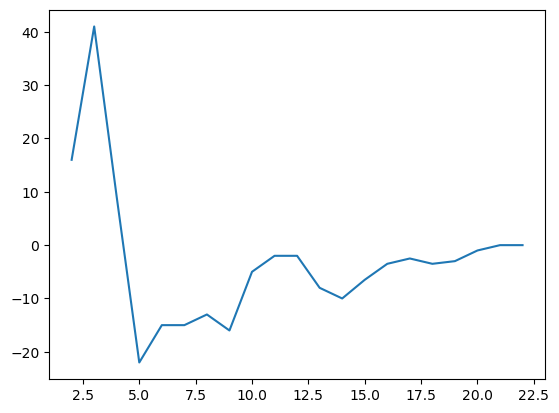

In [17]:
series['Diff2 Key policy rate'].plot()

Спробуємо до кореню квадратного значень ряду побудувати ряд перших різниць

In [18]:
series['sqrt Key policy rate'] = series['Key policy rate'].apply(lambda x: x*0.5).diff(periods=1)

<Axes: >

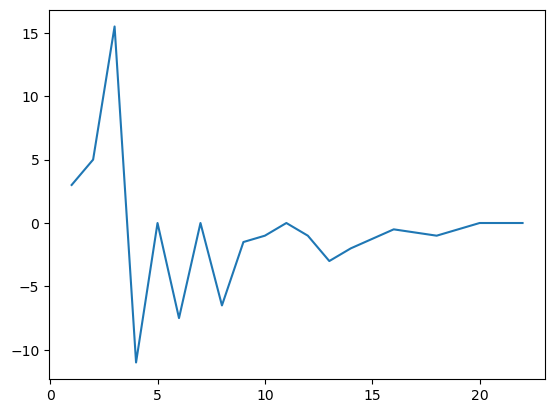

In [19]:
series['sqrt Key policy rate'].plot()

In [20]:
pvalue_KPR = adfuller(series['sqrt Key policy rate'].dropna())[1]

print(pvalue_KPR)

1.0


Бачимо, що за тестом дікі фулера ми підтверджуємо нестаціонарність нашого часового ряду будемо шукати інші варіанти

In [21]:
Спробуємо застосувати логарфмування нашого часового ряду облікової ставки і по ньому виконати побудову ряду перших різниць.

SyntaxError: invalid syntax (381796638.py, line 1)

In [22]:
series['log Key policy rate'] = series['Key policy rate'].apply(lambda x: math.log10(x)).diff(periods=1)

<Axes: >

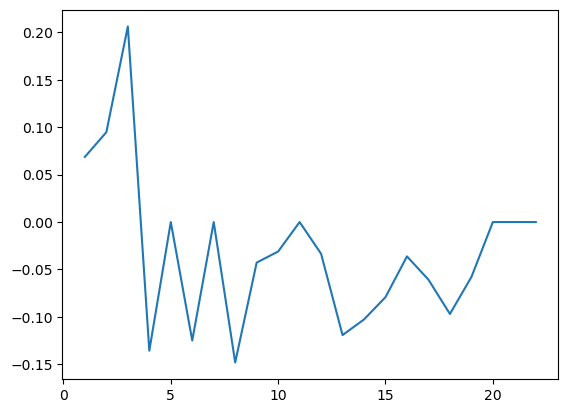

In [23]:
series['log Key policy rate'].plot()

In [24]:
pvalue_KPR = adfuller(series['log Key policy rate'].dropna())[1]

print(pvalue_KPR)

0.5514795397301441


Бачимо, що умова стаціонарності все ще не досягнуто, але ми вже наближаємося до необхідних нам трансформацій. Візьмемо ряд других різниць:

In [25]:
series['log d2 Key policy rate'] = series['Key policy rate'].apply(lambda x: math.log10(x)).diff(periods=2)
pvalue_KPR = adfuller(series['log d2 Key policy rate'].dropna())[1]

print(pvalue_KPR)

0.008512113650885578


<Axes: >

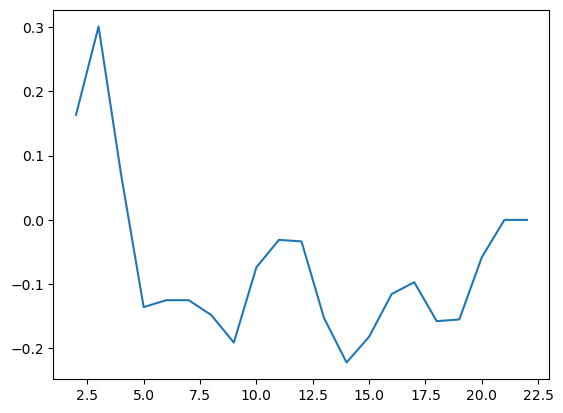

In [26]:
series['log d2 Key policy rate'].plot()

Значення пі велью менше за 0,05 отже ми відхиляємо нульову гіпотезу і наш ряд є стаціонарним. Для побудови моделі облікової ставки використовуємо ряд других різниць після логарфмування.

Ділимо вибірку на навчальну та тестову вибірки:

Наступним етапом дослідження є перевірка каузальності на основі тесту Грейнджера. Перш, ніж перейти до побудови VAR-моделі, необхідно визначити порядок моделі. Для цього розрахуємо значення інформаційних критеріїв для моделей з різною кількістю лагів. 

In [27]:
model_data = pd.DataFrame()
model_data['GDP'] = series['Diff2 GDP'] 
model_data['Investments'] = series['Diff 1 Investment'] 
model_data['KPR'] = series['log d2 Key policy rate']
model_data.dropna(inplace=True)

model_data.head()

,GDP,Investments,KPR
2,8037.0,202.0,0.163502
3,6080.0,3785.0,0.301030
4,-3928.0,-4801.0,0.070581
5,-251.0,1145.0,-0.135663
6,12653.0,1017.0,-0.124939


Null Hypothesis (H0) : Investments do not granger cause GDP.

Alternative Hypothesis (HA) : Investments granger cause GDP.

In [28]:
grangercausalitytests(model_data[['GDP','Investments']], maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0018  , p=0.9663  , df_denom=17, df_num=1
ssr based chi2 test:   chi2=0.0022  , p=0.9629  , df=1
likelihood ratio test: chi2=0.0022  , p=0.9629  , df=1
parameter F test:         F=0.0018  , p=0.9663  , df_denom=17, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9416  , p=0.4133  , df_denom=14, df_num=2
ssr based chi2 test:   chi2=2.5559  , p=0.2786  , df=2
likelihood ratio test: chi2=2.3980  , p=0.3015  , df=2
parameter F test:         F=0.9416  , p=0.4133  , df_denom=14, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4546  , p=0.7193  , df_denom=11, df_num=3
ssr based chi2 test:   chi2=2.2318  , p=0.5257  , df=3
likelihood ratio test: chi2=2.1039  , p=0.5511  , df=3
parameter F test:         F=0.4546  , p=0.7193  , df_denom=11, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6411  , p=0.6481  , df_d

{1: ({'ssr_ftest': (0.0018359564211976225, 0.9663219028854595, 17.0, 1),
   'ssr_chi2test': (0.002159948730820732, 0.9629314615336304, 1),
   'lrtest': (0.0021598321047804347, 0.9629324615813489, 1),
   'params_ftest': (0.001835956421198003, 0.9663219028854595, 17.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.9416442447925966, 0.41334556388558064, 14.0, 2),
   'ssr_chi2test': (2.555891521579905, 0.27860904262417585, 2),
   'lrtest': (2.3979935813457587, 0.3014965243708517, 2),
   'params_ftest': (0.9416442447928658, 0.4133455638854826, 14.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.4546319685968556, 0.7193032097678034, 11.0, 3),
   'ssr_chi2test': (2.231829664020928, 0.5257061612313327, 3),
   'lrtest': (2.1039359813836995, 0.5511168980055665, 3),
   'params_ftest': (0.4546319685967702, 0.7193032097678596, 11.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 

P-value більше за 0,5 приймаємо нульову гіпотезу що ВВП при інших рівних умовах значення ВВП не можуть бути краще передбачені з використанням минулих значень Інвестицій

Null Hypothesis (H0) : GDP do not granger cause Investments.

Alternative Hypothesis (HA) : GDP granger cause Investments.

In [29]:
grangercausalitytests(model_data[['Investments','GDP']], maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5783  , p=0.0757  , df_denom=17, df_num=1
ssr based chi2 test:   chi2=4.2097  , p=0.0402  , df=1
likelihood ratio test: chi2=3.8204  , p=0.0506  , df=1
parameter F test:         F=3.5783  , p=0.0757  , df_denom=17, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=24.4832 , p=0.0000  , df_denom=14, df_num=2
ssr based chi2 test:   chi2=66.4544 , p=0.0000  , df=2
likelihood ratio test: chi2=28.5673 , p=0.0000  , df=2
parameter F test:         F=24.4832 , p=0.0000  , df_denom=14, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0703  , p=0.1624  , df_denom=11, df_num=3
ssr based chi2 test:   chi2=10.1631 , p=0.0172  , df=3
likelihood ratio test: chi2=8.0576  , p=0.0448  , df=3
parameter F test:         F=2.0703  , p=0.1624  , df_denom=11, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1539  , p=0.3984  , df_d

{1: ({'ssr_ftest': (3.5782626985398216, 0.075702896091839, 17.0, 1),
   'ssr_chi2test': (4.209720821811556, 0.040192951600395266, 1),
   'lrtest': (3.820439316115994, 0.050630961387362124, 1),
   'params_ftest': (3.578262698539819, 0.075702896091839, 17.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (24.483206340527442, 2.6861705903772565e-05, 14.0, 2),
   'ssr_chi2test': (66.45441721000306, 3.711988771162057e-15, 2),
   'lrtest': (28.56733832871805, 6.261542037205645e-07, 2),
   'params_ftest': (24.48320634052743, 2.6861705903772636e-05, 14.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.0702688689988173, 0.16241791860968804, 11.0, 3),
   'ssr_chi2test': (10.163138084176012, 0.01722910928499539, 3),
   'lrtest': (8.057559686998673, 0.04483697884022373, 3),
   'params_ftest': (2.0702688689988253, 0.1624179186096868, 11.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0.

P-value менше за 0,5 відхиляємо нульову гіпотезу що при інших рівних умовах значення Інвестиції можуть бути краще передбачені з використанням минулих значень ВВП за лагом 2.

Null Hypothesis (H0) : GDP do not granger cause KPR.

Alternative Hypothesis (HA) : GDP granger cause KPR.

In [30]:
grangercausalitytests(model_data[['KPR','GDP']], maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4697  , p=0.2420  , df_denom=17, df_num=1
ssr based chi2 test:   chi2=1.7290  , p=0.1885  , df=1
likelihood ratio test: chi2=1.6583  , p=0.1978  , df=1
parameter F test:         F=1.4697  , p=0.2420  , df_denom=17, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4284  , p=0.6598  , df_denom=14, df_num=2
ssr based chi2 test:   chi2=1.1629  , p=0.5591  , df=2
likelihood ratio test: chi2=1.1287  , p=0.5687  , df=2
parameter F test:         F=0.4284  , p=0.6598  , df_denom=14, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2303  , p=0.8734  , df_denom=11, df_num=3
ssr based chi2 test:   chi2=1.1305  , p=0.7697  , df=3
likelihood ratio test: chi2=1.0964  , p=0.7779  , df=3
parameter F test:         F=0.2303  , p=0.8734  , df_denom=11, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5123  , p=0.7292  , df_d

{1: ({'ssr_ftest': (1.469673793316704, 0.24197692929210654, 17.0, 1),
   'ssr_chi2test': (1.7290279921372986, 0.18853507954663, 1),
   'lrtest': (1.6583357713022622, 0.19782817454573834, 1),
   'params_ftest': (1.4696737933166963, 0.24197692929210754, 17.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.42841904802212066, 0.6597987910684044, 14.0, 2),
   'ssr_chi2test': (1.1628517017743274, 0.5591006038631992, 2),
   'lrtest': (1.1286552423889873, 0.5687424285788097, 2),
   'params_ftest': (0.42841904800099995, 0.6597987910815358, 14.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.230281367023415, 0.8733881954598778, 11.0, 3),
   'ssr_chi2test': (1.130472165387674, 0.7697235369330228, 3),
   'lrtest': (1.0963927293280733, 0.7779449637603643, 3),
   'params_ftest': (0.23028136702092736, 0.8733881954616011, 11.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0

P-value менше за 0,5 відхиляємо нульову гіпотезу що при інших рівних умовах значення Облікової ставки можуть бути краще передбачені з використанням минулих значень ВВП за лагом 5.

Null Hypothesis (H0) : KPR do not granger cause GDP.

Alternative Hypothesis (HA) : KPR granger cause GDP.

In [31]:
grangercausalitytests(model_data[['GDP','KPR']], maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5493  , p=0.4687  , df_denom=17, df_num=1
ssr based chi2 test:   chi2=0.6462  , p=0.4215  , df=1
likelihood ratio test: chi2=0.6360  , p=0.4252  , df=1
parameter F test:         F=0.5493  , p=0.4687  , df_denom=17, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8993  , p=0.4291  , df_denom=14, df_num=2
ssr based chi2 test:   chi2=2.4409  , p=0.2951  , df=2
likelihood ratio test: chi2=2.2963  , p=0.3172  , df=2
parameter F test:         F=0.8993  , p=0.4291  , df_denom=14, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7262  , p=0.5573  , df_denom=11, df_num=3
ssr based chi2 test:   chi2=3.5648  , p=0.3125  , df=3
likelihood ratio test: chi2=3.2524  , p=0.3543  , df=3
parameter F test:         F=0.7262  , p=0.5573  , df_denom=11, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9071  , p=0.5036  , df_d

{1: ({'ssr_ftest': (0.5492965794844785, 0.4687203381902828, 17.0, 1),
   'ssr_chi2test': (0.6462312699817395, 0.4214633302349967, 1),
   'lrtest': (0.6360104822268227, 0.42515916241994955, 1),
   'params_ftest': (0.5492965794844782, 0.46872033819028447, 17.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.8992610277980576, 0.4291222409078513, 14.0, 2),
   'ssr_chi2test': (2.4408513611661564, 0.2951045199190582, 2),
   'lrtest': (2.2963222398905145, 0.3172195620975905, 2),
   'params_ftest': (0.8992610277980612, 0.42912224090785017, 14.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.7261609384237675, 0.5573308937650541, 11.0, 3),
   'ssr_chi2test': (3.5647900613530403, 0.31245577570360755, 3),
   'lrtest': (3.2524224659981087, 0.3543196350504939, 3),
   'params_ftest': (0.7261609384237676, 0.5573308937650541, 11.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0.

P-value більше за 0,5 приймаємо нульову гіпотезу про те що при інших рівних умовах значення ВВП не можуть бути краще передбачені з використанням минулих значень Облікової ставки.

Null Hypothesis (H0) : KPR do not granger cause Investments.

Alternative Hypothesis (HA) : KPR granger cause Investments.

In [32]:
grangercausalitytests(model_data[['Investments','KPR']], maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2553  , p=0.6198  , df_denom=17, df_num=1
ssr based chi2 test:   chi2=0.3004  , p=0.5836  , df=1
likelihood ratio test: chi2=0.2982  , p=0.5850  , df=1
parameter F test:         F=0.2553  , p=0.6198  , df_denom=17, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3924  , p=0.6826  , df_denom=14, df_num=2
ssr based chi2 test:   chi2=1.0652  , p=0.5871  , df=2
likelihood ratio test: chi2=1.0364  , p=0.5956  , df=2
parameter F test:         F=0.3924  , p=0.6826  , df_denom=14, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2491  , p=0.8603  , df_denom=11, df_num=3
ssr based chi2 test:   chi2=1.2227  , p=0.7476  , df=3
likelihood ratio test: chi2=1.1829  , p=0.7571  , df=3
parameter F test:         F=0.2491  , p=0.8603  , df_denom=11, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3834  , p=0.8149  , df_d

{1: ({'ssr_ftest': (0.25534828840022405, 0.6198225070823858, 17.0, 1),
   'ssr_chi2test': (0.30040975105908707, 0.5836256576465964, 1),
   'lrtest': (0.29817594142548387, 0.5850282077057698, 1),
   'params_ftest': (0.2553482884002211, 0.6198225070823885, 17.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.39243310019948646, 0.6826128499095153, 14.0, 2),
   'ssr_chi2test': (1.0651755576843205, 0.5870837593183345, 2),
   'lrtest': (1.0363887052907899, 0.5955950121846999, 2),
   'params_ftest': (0.39243310019948513, 0.6826128499095164, 14.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.2490625969395129, 0.8603410655447365, 11.0, 3),
   'ssr_chi2test': (1.2226709304303363, 0.7475721789187519, 3),
   'lrtest': (1.1829348395013994, 0.7571000843254968, 3),
   'params_ftest': (0.2490625969395134, 0.8603410655447362, 11.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0

P-value більше за 0,5 приймаємо нульову гіпотезу про те що при інших рівних умовах значення Інвестицій не можуть бути краще передбачені з використанням минулих значень Облікової ставки.

Null Hypothesis (H0) : Investments do not granger cause KPR.

Alternative Hypothesis (HA) : Investments granger cause KPR.

In [33]:
grangercausalitytests(model_data[['KPR','Investments']], maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5463  , p=0.4699  , df_denom=17, df_num=1
ssr based chi2 test:   chi2=0.6427  , p=0.4227  , df=1
likelihood ratio test: chi2=0.6326  , p=0.4264  , df=1
parameter F test:         F=0.5463  , p=0.4699  , df_denom=17, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5282  , p=0.6010  , df_denom=14, df_num=2
ssr based chi2 test:   chi2=1.4337  , p=0.4883  , df=2
likelihood ratio test: chi2=1.3822  , p=0.5010  , df=2
parameter F test:         F=0.5282  , p=0.6010  , df_denom=14, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7281  , p=0.5563  , df_denom=11, df_num=3
ssr based chi2 test:   chi2=3.5742  , p=0.3113  , df=3
likelihood ratio test: chi2=3.2603  , p=0.3532  , df=3
parameter F test:         F=0.7281  , p=0.5563  , df_denom=11, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8493  , p=0.5322  , df_d

{1: ({'ssr_ftest': (0.5462906399559303, 0.4699204923951851, 17.0, 1),
   'ssr_chi2test': (0.6426948705363885, 0.4227366269681513, 1),
   'lrtest': (0.632584479388214, 0.4264088917417177, 1),
   'params_ftest': (0.5462906399559293, 0.4699204923951851, 17.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.528205552031458, 0.6009605994130093, 14.0, 2),
   'ssr_chi2test': (1.433700784085386, 0.4882877515738355, 2),
   'lrtest': (1.382184599223251, 0.5010284968315268, 2),
   'params_ftest': (0.5282055520330419, 0.6009605994121238, 14.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.7280833554062113, 0.556309482363501, 11.0, 3),
   'ssr_chi2test': (3.574227381085037, 0.3112619136908894, 3),
   'lrtest': (3.2602980166228406, 0.35320675679971464, 3),
   'params_ftest': (0.7280833553735334, 0.5563094823808479, 11.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 1.,

P-value більше за 0,5 приймаємо нульову гіпотезу про те що при інших рівних умовах значення Облікової ставки не можуть бути краще передбачені з використанням минулих значень Інвестицій.

In [34]:
maxlag = 5
test = 'ssr_chi2test'
def grangers_causation_matrix(model_data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(model_data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(model_data, variables = model_data.columns)

C:\Users\alona\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\alona\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\alona\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\alona\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\alona\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\alona\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions shou

,GDP_x,Investments_x,KPR_x
GDP_y,1.0,0.0483,0.1028
Investments_y,0.0,1.0000,0.2962
KPR_y,0.0,0.0506,1.0000


Looking at the P-Values in the above table, you can pretty much observe that most of the variables (time series) in the system are interchangeably causing each other.

All of the series in the VAR model should have the same number of observations. Тому нам треба обрати який порядок різниць ми використаємо для моделі. Для двох з трьох моделей для досягнення стаціонарності необхідно було побудувати ряд других різниць, тому ми оберемо його.

*записуємо новий датасет для моделі:*

In [110]:
df_data = pd.DataFrame()
df_data['GDP'] = series['GDP'] 
df_data['Investments'] = series['Investment'] 
df_data['KPR'] = series['Key policy rate']#.apply(lambda x: math.log10(x))
df_data.dropna(inplace=True)

df_data.head()

,GDP,Investments,KPR
0,20871,1744,35.0
1,23367,2675,41.0
2,28908,2877,51.0
3,29447,6662,82.0
4,24980,1861,60.0


In [111]:
train, test = df_data.iloc[0:20], df_data.iloc[20:]
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   GDP          20 non-null     int64  
 1   Investments  20 non-null     int64  
 2   KPR          20 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 612.0 bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 20 to 22
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   GDP          3 non-null      int64  
 1   Investments  3 non-null      int64  
 2   KPR          3 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 204.0 bytes


In [114]:
df_differenced = train.diff().dropna()
df_differenced = df_differenced.diff().dropna()
df_differenced = df_differenced.diff().dropna()

df_differenced.head()

,GDP,Investments,KPR
3,-8047.0,4312.0,17.0
4,-4.0,-12169.0,-74.0
5,13689.0,14532.0,75.0
6,-4462.0,-6074.0,-37.0
7,-14974.0,3750.0,30.0


<Axes: >

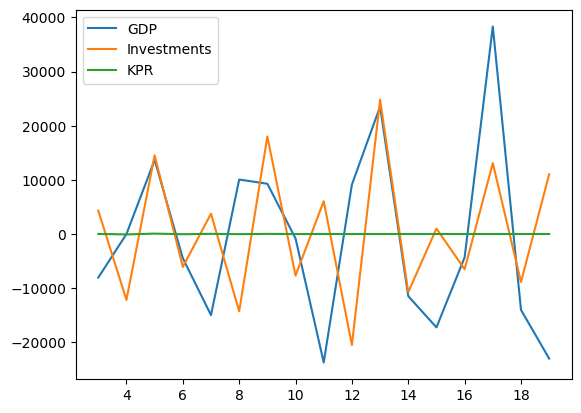

In [113]:
df_differenced.plot()

In [87]:
pvalue = adfuller(df_differenced['GDP'])[1]
pvalue

0.019355817469672805

In [88]:
pvalue = adfuller(df_differenced['Investments'])[1]
pvalue

1.568512293670552e-05

In [89]:
pvalue = adfuller(df_differenced['KPR'])[1]
pvalue

9.394798168615331e-09

    Беремо часовий ряд третього порядку

Ряди є стаціонарними підготуємо навчальну та тестову віибірки:

To select the right order of the VAR model, we iteratively fit increasing orders of VAR model and pick the order that gives a model with least AIC.

Though the usual practice is to look at the AIC, you can also check other best fit comparison estimates of BIC, FPE and HQIC.

In [92]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  43.367020927053005
BIC :  43.94646246873284
FPE :  7.049566492148392e+18
HQIC:  43.39669308786034 

Lag Order = 2
AIC :  40.752849087531835
BIC :  41.74411936907493
FPE :  6.319911732397924e+17
HQIC:  40.74228998779574 

Lag Order = 3
AIC :  34.31972288136036
BIC :  35.68913144482163
FPE :  2388129941514630.0
HQIC:  34.19295908683478 

Lag Order = 4
AIC :  -inf
BIC :  -inf
FPE :  inf
HQIC:  -inf 

Lag Order = 5
AIC :  -143.21460155103614
BIC :  -141.27497495188413
FPE :  -7.305115438511088e-64
HQIC:  -143.93272080411353 

Lag Order = 6
AIC :  -150.30384168666612
BIC :  -148.24202072762003
FPE :  -8.812409391180044e-69
HQIC:  -151.60353099091154 

Lag Order = 7
AIC :  -151.63814581528274
BIC :  -149.64108420152203
FPE :  -4.893381346032824e-71
HQIC:  -153.8289175380097 

Lag Order = 8
AIC :  -149.5602096522791
BIC :  -147.9166715078106
FPE :  -6.175351375157655e-72
HQIC:  -153.1069595160017 

Lag Order = 9
AIC :  -144.65945877188744
BIC :  -143.82532258424916
FPE : 

C:\Users\alona\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


альтернатива побудови:

In [98]:
x = model.select_order()
x.summary()

,AIC,BIC,FPE,HQIC
0,44.07,44.21,1.383e+19,44.06
1,41.04,41.59,7.002e+17,40.99
2,39.82,40.77,2.632e+17,39.73
3,34.32*,35.69*,2.388e+15*,34.19*


Обираємо рекомендований 3 лаг.

In [100]:
#навчання моделі
model_fitted = model.fit(3)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 04, Dec, 2023
Time:                     23:38:17
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    35.6891
Nobs:                     14.0000    HQIC:                   34.1930
Log likelihood:          -269.833    FPE:                2.38813e+15
AIC:                      34.3197    Det(Omega_mle):     4.74033e+14
--------------------------------------------------------------------
Results for equation GDP
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const               -565.470370       871.986272           -0.648           0.517
L1.GDP                -0.886384         0.099815           -8.880           0.000
L1.Investments        -0.259508         0.223133          

#### Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic

Serial correlation of residuals is used to check if there is any leftover pattern in the residuals (errors).

What does this mean to us?

If there is any correlation left in the residuals, then, there is some pattern in the time series that is still left to be explained by the model. In that case, the typical course of action is to either increase the order of the model or induce more predictors into the system or look for a different algorithm to model the time series. 


In [103]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df_differenced.columns, out):
    print(col, ':', round(val, 2))

GDP : 2.53
Investments : 1.53
KPR : 1.98


The value of this statistic can vary between 0 and 4. The closer it is to the value 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.
The serial correlation seems quite alright. Let’s proceed with the forecast.

## Forecast

In [105]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

3


array([[ 3.8324e+04,  1.3092e+04, -2.0000e+00],
       [-1.4010e+04, -8.8670e+03,  0.0000e+00],
       [-2.3004e+04,  1.1040e+04,  1.5000e+00]])

In [115]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=3)
df_forecast = pd.DataFrame(fc, index=df_data.index[-3:], columns=df_data.columns + '_3d')
df_forecast

,GDP_3d,Investments_3d,KPR_3d
20,-12997.355429,-17483.486173,0.731741
21,56482.955439,5234.795568,-6.135535
22,-14338.801446,12947.656804,3.005251


##### Invert the transformation to get the real forecast

In [116]:
def invert_transformation(train, df_forecast, second_diff=False, third_diff=False):
    df_fc = df_forecast.copy()
    columns = train.columns
    for col in columns:
        # Roll back 3rd Diff
        if third_diff:
            df_fc[str(col)+'_2d'] = (train[col].iloc[-1] - 2 * train[col].iloc[-2] + train[col].iloc[-3]) + df_fc[str(col)+'_3d'].cumsum()
        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (train[col].iloc[-1] - train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
        
    return df_fc

In [122]:
df_results = invert_transformation(train, df_forecast, second_diff=True, third_diff=True)        
df_results.loc[:, ['GDP_forecast', 'Investments_forecast', 'KPR_forecast']]
    


,GDP_forecast,Investments_forecast,KPR_forecast
20,34429.644571,18503.513827,7.731741
21,34075.889152,16494.337049,4.059688
22,47858.932298,24259.126470,-1.010909


# Plot

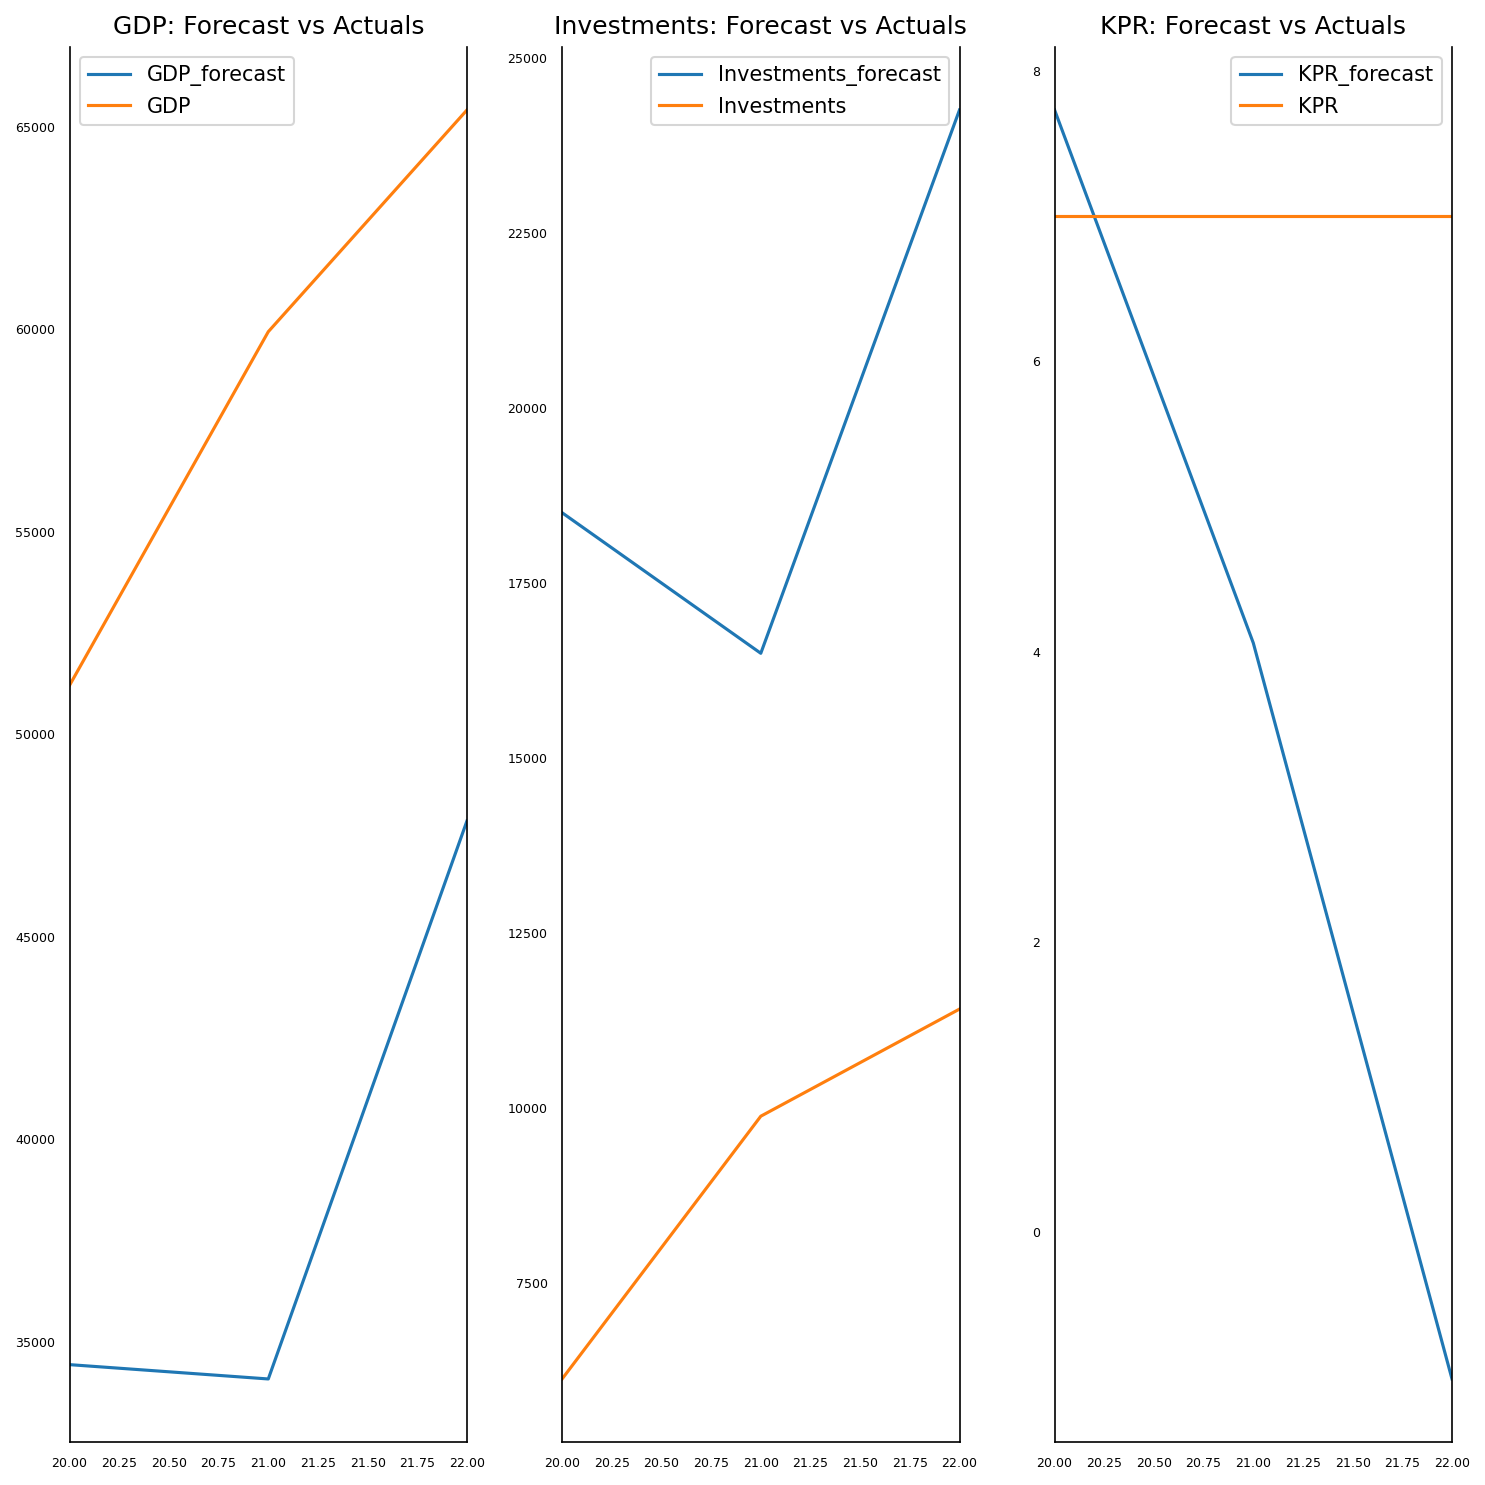

In [126]:
fig, axes = plt.subplots(nrows=int(len(df_data.columns)/2), ncols=3, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df_data.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    test[col][-3:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

## Evaluate the Forecasts

In [132]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: GDP')
accuracy_prod = forecast_accuracy(df_results['GDP_forecast'].to_numpy(), test['GDP'].to_numpy())
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: Investments')
accuracy_prod = forecast_accuracy(df_results['Investments_forecast'].to_numpy(), test['Investments'].to_numpy())
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: KPR')
accuracy_prod = forecast_accuracy(df_results['KPR_forecast'].to_numpy(), test['KPR'].to_numpy())
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))


Forecast Accuracy of: GDP
mape :  0.3425
me :  -20063.8447
mae :  20063.8447
mpe :  -0.3425
rmse :  20480.7914
corr :  0.7791
minmax :  0.3425

Forecast Accuracy of: Investments
mape :  1.2724
me :  10614.6591
mae :  10614.6591
mpe :  1.2724
rmse :  10986.5842
corr :  0.5286
minmax :  0.5333

Forecast Accuracy of: KPR
mape :  0.5563
me :  -3.4065
mae :  3.8943
mpe :  -0.4866
rmse :  4.9449
corr :  nan
minmax :  0.553


C:\Users\alona\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\alona\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
